# Задача: 
Предсказать, кто из пассажиров титаника выживет, а кто умрет.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

from sklearn.model_selection import cross_val_score 

In [83]:
# Визуализация
from IPython.display import SVG, display, HTML
from graphviz import Source

style = "<style>svg{width: 10% !important; height: 10% !important;}</style>"
HTML(style)
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin" + os.pathsep + "C:\\Program Files\\Graphviz"

Загрузка данных

In [84]:
# Данные на которых модель будет обучаться
train_data = pd.read_csv('train.csv', index_col='PassengerId')
train_data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
# Данные на котрых модель будет предсказывать
test_data = pd.read_csv('test.csv', index_col='PassengerId')
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [86]:
# Данные для проверки
y = pd.read_csv('gender_submission.csv', index_col='PassengerId')
y.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


# Подготавливаем данные

In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 46.1 KB


In [88]:
X_train = train_data.drop(['Name', 'Survived', 'Ticket', 'Cabin'], axis=1) # То на чем модель будет учится
y_train = train_data.Survived # То что модель будет предсказывать при обучении
X_test  = test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1) # Данные для предсказания

In [89]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [90]:
X_train = pd.get_dummies(X_train) # Преобразование категориальных переменных в индикаторные переменные
X_train = X_train.fillna({'Age': X_train.Age.median()}) # Заполняем пропуски в возрасте серединным значением

In [91]:
X_test = pd.get_dummies(X_test) 
X_test= X_test.fillna({'Age': X_test.Age.median(),
                        'Fare': X_test.Fare.median()})
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 21.6 KB


# Обучаем дерево решений
### Ищем наилучшие параметры для дерева решений

In [92]:
from sklearn.model_selection import GridSearchCV 

tree_clf = tree.DecisionTreeClassifier() # Создаем дерево

In [93]:
parametrs = {'criterion':['gini', 'entropy'], 'max_depth': range(1, 30)} # Определяем возможные параметры 
grid_search_cv_clf = GridSearchCV(tree_clf, param_grid=parametrs, cv=5) # Находим подходящие параметры

Обучаем дерево

In [94]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [95]:
grid_search_cv_clf.best_params_ # Лучшие параметры для максимального accurecy в кросвалидации

{'criterion': 'entropy', 'max_depth': 8}

In [96]:
best_clf = grid_search_cv_clf.best_estimator_ # Дерево с этими парраметрами

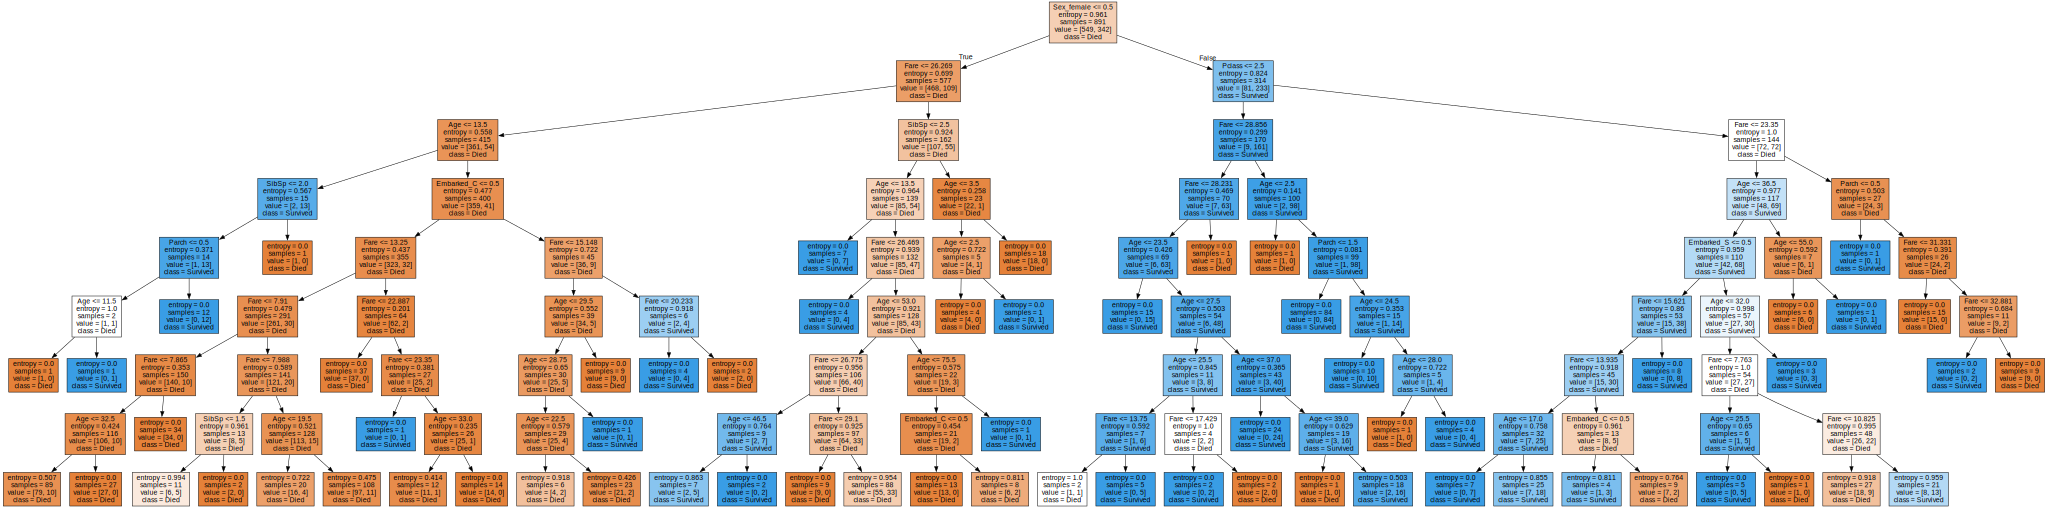

In [97]:
graph = Source(tree.export_graphviz(best_clf, out_file=None, feature_names=list(X_train), \
    class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [98]:
predictions = best_clf.predict(X_test)

In [99]:
y_test = pd.DataFrame({'Survived': predictions}, index=X_test.index)
y_test.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [101]:
best_clf.score(X_test, y)

0.8732057416267942

In [103]:
y_test.to_csv('submission_tree.csv')

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier